# Averaging technical replicates

Each biological sample was run in triplicates. Taking geometric mean of technical replicates.

Example data are from
Li et al. (2013) Predicting network activity from high throughput metabolomics. PLoS computational biology 9.7 (2013): e1003123.


In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

%matplotlib inline

INDIR = "../input_data/"
datafile = "modc_ae_2012.txt"
data = pd.read_table(os.path.join(INDIR + datafile))
data.head()

,mz,time,mz.min,mz.max,p_0hr_01_1,p_0hr_01_3,p_0hr_01_5,p_0hr_02_1,p_0hr_02_3,p_0hr_02_5,...,mock_6hr_03_5,yf_6hr_01_1,yf_6hr_01_3,yf_6hr_01_5,yf_6hr_02_1,yf_6hr_02_3,yf_6hr_02_5,yf_6hr_03_1,yf_6hr_03_3,yf_6hr_03_5
0,85.02783,59.68820,85.02783,85.02783,15.5810,16.0425,15.3953,15.4143,15.7364,15.5532,...,17.5140,17.1734,16.9813,16.6582,16.8376,16.8148,17.2885,16.5967,16.4734,16.6048
1,85.04717,124.75120,85.04709,85.04739,14.4754,14.2709,14.3696,14.7142,14.8291,14.9959,...,16.6485,16.6961,16.3596,17.0661,15.2321,15.1615,16.5655,16.4316,16.1668,16.2193
2,85.06532,68.66651,85.06517,85.06547,14.4223,15.0515,15.1241,13.5224,16.7480,14.4095,...,9.7859,14.0113,15.8681,13.3699,9.9658,15.5703,16.5537,11.9470,10.3181,10.1656
3,85.10073,16.48022,85.10050,85.10078,14.5249,13.2573,13.5206,12.9044,11.4185,12.9223,...,13.3513,13.2977,13.1140,12.5569,12.9582,12.9960,13.0290,12.4184,13.0218,13.4085
4,86.05951,67.78485,86.05949,86.05980,10.6674,17.4235,17.4510,17.0197,17.0402,16.9958,...,18.5019,17.7391,17.9262,17.6089,17.5802,17.6529,17.7841,17.3077,10.7589,17.3895


This is a dataset of human monocyte-derived dendritic cells (moDC). Three experimental groups are baseline control, mock infection at 6 hours, YFV infection at 6 hours. Each group contains three biological replicates. Each biological replicate was analyzed by LC-MS in three technical replicates. This above table was extracted using apLCMS.

## Checking data quality by

* average ion intensity in each sample
* correlation coefficient between technical replicates

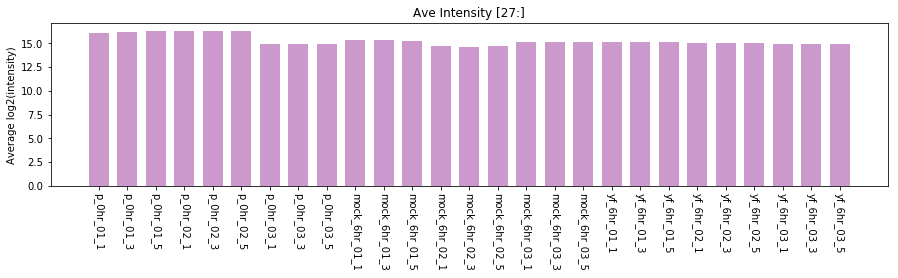

In [3]:
new_header = [x for x in data]

# if needed to transform to log2, shift positive 1 to avoid log2(0)
# new_data = np.log2(mydata[ new_header[4:] ] + 1)

new_data = data[new_header[4:]]

mean_TIC = new_data.mean(0)
# plot bars for first N columns, useful if large number of samples
N = 27
ind = np.arange(N)
plt.figure(figsize=(15,3))
plt.bar(ind, mean_TIC[:N], width=0.7, color="purple", alpha=0.4)
plt.ylabel("Average log2(intensity)")
plt.title("Ave Intensity [%d:]" %N)
plt.xticks(ind, new_data.columns[:N], rotation=-90)
plt.show()

# one should be alarmed if irregularity is spotted. Replicate of low intensity may be subject of removal.
# Alternatively, pandas dataframe has built-in plotting too (also via matplotlib)

In [4]:
# We are making a new dictionary to map samples to replicates

def remove_tail(x):
    return("_".join(x.split("_")[:-1]))

samples = [remove_tail(x) for x in new_header[4:]]
print("After remove_tail: ", samples[:6])

samples = set(samples)
samDict = {}
for x in new_header[4:]:
    k = remove_tail(x)
    if samDict.has_key(k):
        samDict[k].append(x)
    else:
        samDict[k] = [x,]

print("Example sample dictionary:")
print(samDict.items()[:3])

('After remove_tail: ', ['p_0hr_01', 'p_0hr_01', 'p_0hr_01', 'p_0hr_02', 'p_0hr_02', 'p_0hr_02'])
Example sample dictionary:
[('yf_6hr_02', ['yf_6hr_02_1', 'yf_6hr_02_3', 'yf_6hr_02_5']), ('yf_6hr_03', ['yf_6hr_03_1', 'yf_6hr_03_3', 'yf_6hr_03_5']), ('yf_6hr_01', ['yf_6hr_01_1', 'yf_6hr_01_3', 'yf_6hr_01_5'])]


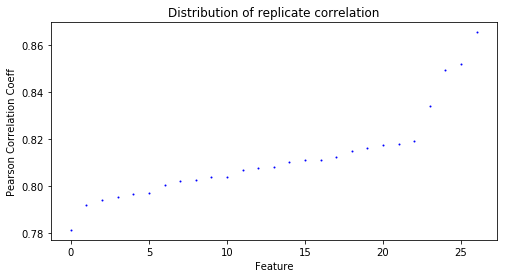

In [5]:
# Pearson correlation btw technical replicates
# plot first before deciding CUTOFF value

def get_flat_corr(CorrDataFrame):
    return [CorrDataFrame.values[0, 1], CorrDataFrame.values[0, 2], CorrDataFrame.values[1, 2]]

all_Pearson_coefficients = []
for k,v in samDict.items():
    if len(v) == 3:  # only do if three replicates
        Pr = new_data[v].corr()
        all_Pearson_coefficients.append((v, Pr))

all_corr_values = []
for X in all_Pearson_coefficients: 
    all_corr_values += get_flat_corr(X[1])
    
# This is useful where sample nubmer is large
all_corr_values.sort()
plt.figure(figsize=(8,4))
plt.plot(range(len(all_corr_values)), all_corr_values, 'bo', markersize=1)
plt.title("Distribution of replicate correlation")
plt.xlabel("Feature")
plt.ylabel("Pearson Correlation Coeff")
plt.show()

In [6]:
# This block is to remove bad replicates.
#
# CUTOFF is based on plot above; this is usually dragged down by too many zeros
# This does nothing because the worst is 0.78 in above figure
corr_CUTOFF = 0.7

# Deterine which replicate to remove
def call_bad_replicate(CorrDataFrame, corr_CUTOFF):
    # assuming three replicates here, 
    # return list of bad replicates
    names = [x for x in CorrDataFrame]
    good = []
    if CorrDataFrame.values[0, 1] > corr_CUTOFF:
        good += [names[0], names[1]]
        
    if CorrDataFrame.values[0, 2] > corr_CUTOFF:
        good += [names[0], names[2]]
        
    if CorrDataFrame.values[1, 2] > corr_CUTOFF:
        good += [names[1], names[2]]

    return [x for x in names if x not in good]


bad_replicates = []
for X in all_Pearson_coefficients:
    bad = call_bad_replicate(X[1], corr_CUTOFF)
    if bad:
        bad_replicates += bad
        print("- Bad corr - %s" %str(bad))
        # uncomment below to see the whole corr matrix
        #print(Pr)
    
# In some dataset, many Qstd samples have the same name. Skipping them for now.
# Alternative method can use stats.pearsonr and itertools.combinations


## Averaging technical replicates
Since data are already in log2, myave function is actually taking geometric means.

In [8]:
def myave(L):
     new = [x for x in L if x >1]
     if new:
         return np.mean(new)
     else:
         return 0
        
# update samDict
# this is used when bad replicates need to be excluded
# black_list = set(low_intensity_replicates + bad_replicates)
# 
black_list = []
samDict2 = {}
for k,v in samDict.items():
    new = [x for x in v if x not in black_list]
    if new:
        # We may want to keep NIST and Q-std samples for other reasons including downstream QC
        if 'nist' not in k and 'q3' not in k:
            samDict2[k] = new

# Write ave_log2_ data
use_samples = samDict2.keys()
use_samples.sort()
s = 'mz\tretention_time\t' + '\t'.join(use_samples) + '\n'

# mydata contains mz, this set of data is already in log2
print(data.shape)
num_features = data.shape[0]

print("use_samples", use_samples[:3])
print(samDict2[use_samples[2]])

# mapper is faster than DataFrame lookup
new_data_header = [x for x in new_data]
mapper = []
for x in use_samples:
    mapper.append([new_data_header.index(ii) for ii in samDict2[x]])

for ii in range(num_features):
    mz, rtime = data.values[ii, :2]
    d = new_data.values[ii, :]
    ave_data = [myave( [d[ii] for ii in x] ) for x in mapper]
    s += '\t'.join( [str(mz), str(int(rtime)), ] + [str(round(x,2)) for x in ave_data] ) + '\n'
    
new_file = "ave_log2_" + datafile
with open(new_file, 'w') as file:
    file.write(s)

(7995, 31)
('use_samples', ['mock_6hr_01', 'mock_6hr_02', 'mock_6hr_03'])
['mock_6hr_03_1', 'mock_6hr_03_3', 'mock_6hr_03_5']


## Summary
The above code illustrates simple QC and averaging replicates.

Not covered here, but filtering, normalization and imputation is often needed.
Missing values can be problematic for some statistical methods, including linear regression. Data should be filtered to have fewer missing values.
The missing values can be imputed by replacement of minimal values of a feature row (i.e. minimal detected values in the same feature). Other imputation methods are available too.
Imputation may be performed prior to normalization, as the normalization method may be sensitive to missing data.